In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd())) 

In [2]:
import scipy.optimize as optim
import numpy as np
import pandas as pd
import siunits as unit

from scipy.integrate import trapezoid
from scipy.constants import epsilon_0, elementary_charge, Boltzmann, Avogadro
from src.helper_functions import read_render_markdown_file, make_simple_plot

### Physical constants

1. the electric constant (vacuum permittivity) $\epsilon_0$. Units:  $\textstyle{\rm s^{4}\cdot A^{2}\cdot kg^{-1}\cdot m^{-3}}$ or $\textstyle{\rm C^2 \cdot N^{−1} \cdot m^{−2}}$ or $\textstyle{\rm C \cdot V^{−1} \cdot m^{−1}}$ 

In [3]:
unit.epsilon_0

ampere²·second⁴·meter⁻³·kilogram⁻¹ (A²·s⁴·m⁻³·kg⁻¹), [kg: -1, s: 4, A: 2, m: -3]

In [4]:
epsilon_0

8.8541878128e-12

2. Elementary charge (charge on electron). Units: $\rm C$

In [5]:
unit.c

coulomb (C), [s: 1, A: 1]

In [6]:
elementary_charge

1.602176634e-19

3. Boltzmann constant. Units: $\rm m^2 \cdot kg \cdot s^{-2} \cdot {K}^{-1}$

In [7]:
Boltzmann

1.380649e-23

4. Avogadro's number. Units: $\rm mol^{-1}$

In [8]:
Avogadro

6.02214076e+23

### Singlet model parameters

See Page 62

In [9]:

component = ["K", "Cl"]            # KCl (potassium chloride)
valence = np.array([1.0, -1.0])    # 1-1 electrolyte
n_component = len(component)

In [10]:
temperature = 1075.0               # 1075 K
concentration = 19.265             # mol dm^{-3}

In [11]:
psi_0 = 0     # 0 mV

rho ($\rho$) is the number density which we calculate from the concentration ($c$):

$\rho = c \, \rm mol \, dm^{-3} \cdot dm^{3} / 1.0 \cdot 10^{27} \cdot A^{3} \cdot N_{A} \, mol^{-1}$. Units: $\rm A^{-3}$


In [12]:
def calc_rho(concentration):
    return np.array([concentration, concentration]) / 1.0e27 * Avogadro

In [13]:
rho = calc_rho(concentration)

In [14]:
rho   # values seem reasonable (compared with those in thesis)

array([0.01160165, 0.01160165])

In [15]:
def calc_charge(valence):
    return valence * elementary_charge

In [16]:
charge = calc_charge(valence)

In [17]:
charge  # units are C

array([ 1.60217663e-19, -1.60217663e-19])

In [18]:
epsilon = 4.0 * np.pi * epsilon_0   # units same as $\epsilon_0$

In [19]:
epsilon

1.1126500554478704e-10

$\beta = 1 / k T$. Units: $\rm m^{-2} \cdot kg^{-1} \cdot s^{2}$

In [20]:
beta = 1.0 / (Boltzmann * temperature)

In [21]:
beta

6.737646991665042e+19

$\beta^{-1} = k T$. Units: $\rm m^{2} \cdot kg \cdot s^{-2}$

In [22]:
beta_inv = Boltzmann * temperature

In [23]:
beta_inv

1.484197675e-20

In [24]:
def calc_kappa(beta, rho, epsilon):
    return np.sqrt(4.0 * np.pi * beta / epsilon * 1e10 *
    sum(np.multiply(charge**2, rho)))


In [25]:
kappa = calc_kappa(beta, rho, epsilon)

In [26]:
kappa      # similar to thesis value (6.77) page 62 - maybe revisions to physical constants in past 25 years (e.g. 2019 change for $e$)

6.732325586635704

### Discretisation of functions

In [27]:
z_cutoff = 50.0
n_point = 2001
grid_size = z_cutoff / (n_point - 1) 
z = np.linspace(0.0, z_cutoff, n_point)

print(grid_size)

0.025


### Wall-ion soft-potential

In [28]:
phiw = np.zeros((n_point, n_component))
hw = np.zeros((n_point, n_component))
tw = np.zeros((n_point, n_component))
int_0_z = np.zeros((n_point, n_component))
int_z_inf = np.zeros((n_point, n_component))

In [29]:
# same for both ions

def calc_phiw(z, n_component):
    capital_a = 16.274e-19 # joules
    wall_d = 2.97  # inverse Angstrom
    for i in range(n_component):
        phiw[:, i] = np.exp(-wall_d * z) * capital_a * (wall_d * z + 2)
    return phiw


In [30]:
beta_phiw = beta * calc_phiw(z, n_component)

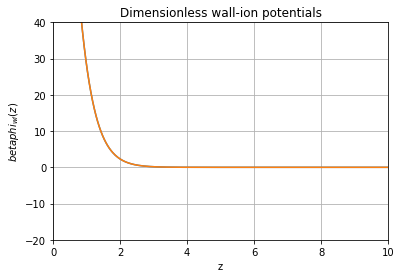

'Dimensionless wall-ion potentials'

In [31]:
make_simple_plot(z, beta_phiw, "z", "$beta phi_{wi}(z)$", "Dimensionless wall-ion potentials")

This dimensionless plot matches well with Figure 4.1(b) of thesis.

### Bulk fluid inputs

Not sure what to do here -- maybe run pyOZ for ionic fluid and try using c_{ij}(r) from this as an approximation?

In [32]:
read_render_markdown_file("../docs/equation_3_4.md")

$$ f_{ij}^{(n)}(z) = \int_z^{\infty} dr r^n c_{ij}^{*} $$

In [33]:
# Assume all of the moments of the short-ranged bulk direct correlation functions to be zero initially

n_pair = int((n_component+1) * (n_component) / 2)

f1 = np.zeros((n_point, n_pair))
f2 = np.zeros((n_point, n_pair))
c_short = np.zeros((n_point, n_pair))

In [34]:
# Read in some c(r)
def load_cr():
    CR_PATH = "../pyOZ_bulk_fluid/tests/lj_chg/nrcg-cr.dat.orig"
    cr = pd.read_csv(CR_PATH, header=None, delim_whitespace=True)
    cr.set_index(0, inplace=True)
    return cr



<AxesSubplot:xlabel='0'>

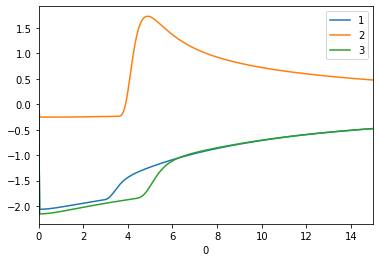

In [35]:
cr = load_cr()
cr.plot(xlim=[0, 15])

In [36]:
# for now assume c*(r) = c(r)

c_short = cr.to_numpy(dtype=np.float64)

In [37]:
r = cr.index.to_numpy()

In [38]:
r[0]

0.0

In [39]:
c_short[1:].shape

(4095, 3)

In [40]:
charge_pair = np.array([1, -1, 1]) * elementary_charge

In [41]:
charge_pair

array([ 1.60217663e-19, -1.60217663e-19,  1.60217663e-19])

In [42]:
c_short[1:].shape

(4095, 3)

In [43]:
r[1:].shape

(4095,)

In [44]:
beta, epsilon

(6.737646991665042e+19, 1.1126500554478704e-10)

In [47]:
read_render_markdown_file("../docs/equation_3_5.md")

$$ c_{ij}^*(r) = c_{ij}(r) + \beta q_i q_j / (\varepsilon r) $$

In [48]:
charge_pair

array([ 1.60217663e-19, -1.60217663e-19,  1.60217663e-19])

In [54]:
type(charge_pair)

numpy.ndarray

In [53]:
charge_pair.shape, np.transpose(r[1:]).shape

((3,), (4095,))

In [57]:
type(r[1:])

numpy.ndarray

In [61]:
m = r[1:10]

In [62]:
m

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45])

In [97]:
tmp = np.matmul(np.transpose([1 / r[1:]]), np.transpose([charge_pair]).T)

In [99]:
tmp.shape

(4095, 3)

In [95]:
np.transpose([r[1:]]).shape

(4095, 1)

In [96]:
np.transpose([1 / r[1:]]).shape

(4095, 1)

In [85]:
[charge_pair]

[array([ 1.60217663e-19, -1.60217663e-19,  1.60217663e-19])]

In [100]:
# skip r = 0

c_short[1:] = c_short[1:] + beta * tmp / epsilon

In [102]:
c_short

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.94039456e+12, -1.94039456e+12,  1.94039456e+12],
       [ 9.70197280e+11, -9.70197280e+11,  9.70197280e+11],
       ...,
       [ 4.74076365e+08, -4.74076365e+08,  4.74076365e+08],
       [ 4.73960567e+08, -4.73960567e+08,  4.73960567e+08],
       [ 4.73844826e+08, -4.73844826e+08,  4.73844826e+08]])

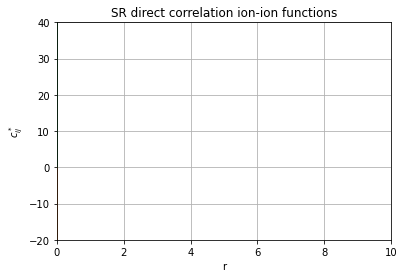

'SR direct correlation ion-ion functions'

In [101]:
make_simple_plot(r, c_short, "r", "$c_{ij}^*$", "SR direct correlation ion-ion functions")

In [ ]:
def int_z_infty_dr_r_c_short(c_short, z):
    for ij in range(n_pair):
        for k, _ in enumerate(z):
            f1[k, ij] = trapezoid(y=z[:k] * c_short[k, ij], x=z[:k])
    return f1

In [ ]:
def int_z_infty_dr_r2_c_short(c_short, z):
    for ij in range(n_pair):
        for k, _ in enumerate(z):
            f2[k, ij] = trapezoid(y=z[:k] * z[:k] * c_short[k, ij], x=z[:k])
    return f2

In [ ]:
f1 = int_z_infty_dr_r_c_short(c_short, z)

In [ ]:
make_simple_plot(z, f1, "z", "$f_{ij}(z)$", "Moment 1 of c^*(r)")

In [ ]:
f2 = int_z_infty_dr_r2_c_short(c_short, z)

In [ ]:
make_simple_plot(z, f2, "z", "$f2_{ij}(z)$", "Moment 2 of c^*(r)")

Initial guess for solution $t_{wi}(z)$ - solving $F(t(z)) = 0$

In [ ]:
tw = np.zeros((n_point, n_component))    # initial guess of zero - maybe should be \beta \phi

# tw = beta_phiw_i

In [ ]:
make_simple_plot(z, tw, "z", "$t_{wi}(z)$", "Initial guess for $t_{wi}(z)$")

In [ ]:
def calc_hw(tw, beta_phiw):
    for i in range(n_component):
        hw[:, i] = np.exp(tw[:, i]) * np.exp(-beta_phiw[:, i]) - 1.0
        return hw


In [ ]:
hw = calc_hw(tw, beta_phiw)

In [ ]:
make_simple_plot(z, hw, "z", "$h_{wi}(z)$", "Initial version of $h_{wi}(z)$")

In [ ]:
read_render_markdown_file("../docs/equation_5_9.md")
read_render_markdown_file("../docs/equation_5_9b.md")

In [ ]:
beta_psi =  psi_0 * charge * beta

In [ ]:
def calc_tw(tw, beta_psi, beta_phiw, rho, f1, f2, z):
    hw = calc_hw(tw, beta_phiw)

    for i in range(n_component):
        for k, _ in enumerate(z):
            int_0_z[k, i] = trapezoid(y=z[:k] * hw[:k, i], x=z[:k])
            int_z_inf[k, i] = trapezoid(y=hw[k:, i], x=z[k:])
            for j in range(n_component):
            
            #TODO: Complete adding f_ij(z) terms - need to fix sum_{ij} for f functions

                tw[k, i] = -beta_psi[i] + 2.0 * np.pi * (rho[i] * z[k] * f1[k, i] - f2[k, i]) + \
                2.0 * charge[i] * charge[j] / epsilon * (int_z_inf[k, i] + z[k] * int_0_z[k, i])  # + int_0_inf
    return tw


In [ ]:
calc_tw(tw, beta_psi, beta_phiw, rho, f1, f2, z)

In [ ]:
make_simple_plot(z, tw, "z", "$t_{wi}(z)$", "Initial version of $t_{wi}(z)$")

### Numerical solver: Newton-GMRES

In [ ]:
# this should equal 0 (as t(z) converges to solution)

def func_opt(tw):
    return tw - calc_tw(tw, beta_psi, beta_phiw, rho, f1, f2, z)

In [ ]:
tolerance = 1e-9

In [ ]:
solution = optim.root(func_opt, tw, method="krylov", jac=None, tol=tolerance, callback=None, options=None)

In [ ]:
tw_solution = solution.x

In [ ]:
tw_solution